# Netflix Dataset Analysis
## Goals
#### Example scenario
The content team wish to make some data driven decisions about how they can best serve their global audiences. They want the analytics team to examine their historical offerings, and generate some insight about which categories of content are under represented internationally versus domestically (USA). 
#### Purpose Statement
The purpose of this study is to, from a high level, determine if any differences exist between the patterns or trends that might exist within the historical dataset, and to examine its shape, so that this information can be used to direct future non-domestic content decisions. 
#### Research Questions
- Which genres of content, by number of titles added, grew the most/least during the last five years?
- How has the distribution of new content, by genre and type, changed over the last five years?
- What are the differences in trends in overall growth between domestic and non domestic offerings, measured by number of titles added?

#### Data
The source of the data used in this analysis is kaggle.
The licensing of the data is Public Domain, meaning it is available for any purpose, and its publisher does not retain any rights to it. 

In [1]:
import pandas as pd

In [14]:
df = pd.read_csv('netflix_titles.csv')
print('Number of Rows: ', df.shape[0])
print('Features: ')
for f in df.columns: 
    print(' ',f)

df.drop(columns=['title', 'director', 'cast', 'release_year', 'rating', 'description'], inplace=True)    
df.head()


Number of Rows:  6234
Features: 
  show_id
  type
  title
  director
  cast
  country
  date_added
  release_year
  rating
  duration
  listed_in
  description


,show_id,type,country,date_added,duration,listed_in
0,81145628,Movie,"United States, India, South Korea, China","September 9, 2019",90 min,"Children & Family Movies, Comedies"
1,80117401,Movie,United Kingdom,"September 9, 2016",94 min,Stand-Up Comedy
2,70234439,TV Show,United States,"September 8, 2018",1 Season,Kids' TV
3,80058654,TV Show,United States,"September 8, 2018",1 Season,Kids' TV
4,80125979,Movie,United States,"September 8, 2017",99 min,Comedies


# Examination of data 
Upon examination, we can see that the data: 
- Contains 6,234 records
- Consiststed of 12, now 6 columns

The features of this dataset will be sufficient for answering the research questions.
Many of the features are not relevant to the research questions, hence they can be discarded. 

# Research Question 1: Which genres of content, by number of titles added, grew the most/least during the last five years?
To answer this, records must be filtered to include only the last  years of data.
Then, for each record, the categories in the 'listed_in' column will be added to a tally.

In [19]:
df['date_added'] = pd.to_datetime(df['date_added'])

In [23]:
df1 = df[['date_added', 'listed_in']]
df1 = df1[df1['date_added'] >= '2016']
df1.head()

,date_added,listed_in
0,2019-09-09,"Children & Family Movies, Comedies"
1,2016-09-09,Stand-Up Comedy
2,2018-09-08,Kids' TV
3,2018-09-08,Kids' TV
4,2017-09-08,Comedies


In [35]:
categories = []
for index, row in df1.iterrows():
    cats = row['listed_in'].split(',')
    for c in cats: 
        categories.append(c.strip())
    
set(categories)

{'Action & Adventure',
 'Anime Features',
 'Anime Series',
 'British TV Shows',
 'Children & Family Movies',
 'Classic & Cult TV',
 'Classic Movies',
 'Comedies',
 'Crime TV Shows',
 'Cult Movies',
 'Documentaries',
 'Docuseries',
 'Dramas',
 'Faith & Spirituality',
 'Horror Movies',
 'Independent Movies',
 'International Movies',
 'International TV Shows',
 "Kids' TV",
 'Korean TV Shows',
 'LGBTQ Movies',
 'Movies',
 'Music & Musicals',
 'Reality TV',
 'Romantic Movies',
 'Romantic TV Shows',
 'Sci-Fi & Fantasy',
 'Science & Nature TV',
 'Spanish-Language TV Shows',
 'Sports Movies',
 'Stand-Up Comedy',
 'Stand-Up Comedy & Talk Shows',
 'TV Action & Adventure',
 'TV Comedies',
 'TV Dramas',
 'TV Horror',
 'TV Mysteries',
 'TV Sci-Fi & Fantasy',
 'TV Shows',
 'TV Thrillers',
 'Teen TV Shows',
 'Thrillers'}

This is a good overview, but many categories are sub divided into movies and tv, which is redundant since there's already a feature for this, and it provides undesired granularity for this study. The study will be reconducted, this time removing references to Movies or TV shows, and merging tv/movies together. 

<AxesSubplot:title={'center':'Total number of titles added by genre 2016-2020'}>

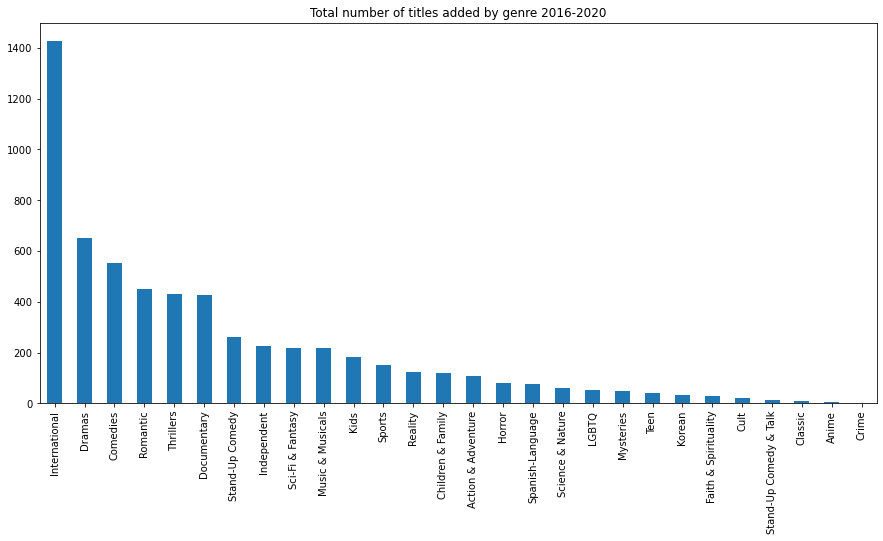

In [87]:
def recode_category(original, keyword, new): 
    if keyword in original:
        return new
    else:
        return original

years = []
categories = []

for index, row in df1.iterrows():
    cats = row['listed_in'].split(',')
    for c in cats: 
        recoded_category = c.replace('TV', '').replace('Shows', '').replace('Movies', '').replace("'", '').strip() 
        recoded_category = recode_category(recoded_category, 'Anime', 'Anime')
        recoded_category = recode_category(recoded_category, 'Docu', 'Documentary')
    
        year = row['date_added'].year
    if year and recoded_category: 
        categories.append(recoded_category)
        years.append(year)

categoriesdf = pd.DataFrame({'Category': categories, 'Year Added': years})
categoriesdf['Category'].value_counts().plot(kind='bar', figsize=(15, 7), title='Total number of titles added by genre 2016-2020')

The top 10 gainers over the 5 years are International, Dramas, Comedies, Romantic, Thrillers, Documentary, Stand-Up Comedy, Independednt, Sci-Fi & Fantasy, and Music & Musicals.

In [132]:
top10 = list(categoriesdf['Category'].value_counts().head(10).index)

Text(0, 0.5, 'Number of Titles Added')

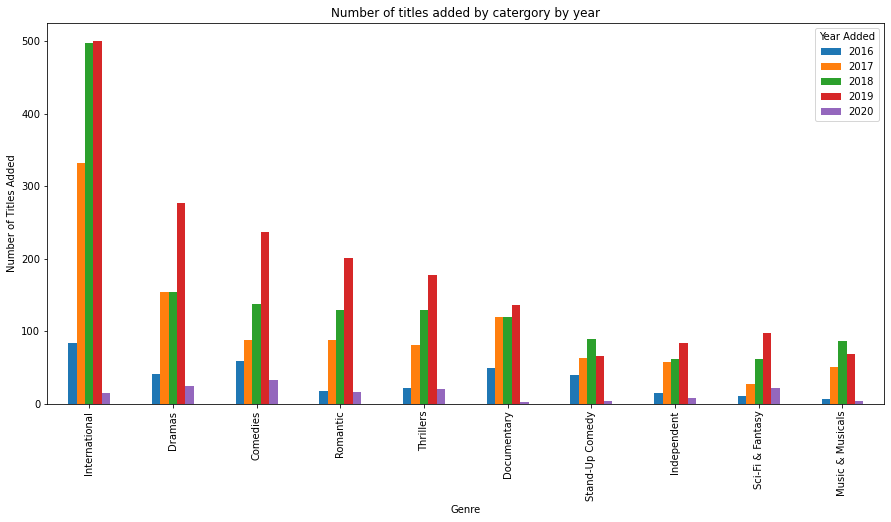

In [135]:
categoriesbyyear = categoriesdf.groupby(['Category', 'Year Added']).size()

x = categoriesbyyear.to_frame().unstack()
x.columns = x.columns.droplevel()
top10df = x[x.index.isin(top10)]

ax = top10df.reindex(top10).plot(kind='bar', figsize=(15,7), title='Number of titles added by catergory by year');
ax.set_xlabel("Genre")
ax.set_ylabel("Number of Titles Added")

### Answering the research question:
The genres of offerings that grew the most have been identified, as have the least gaining genres.

# Research Question 2: How has the distribution of new content, by genre and type, changed over the last five years?
To answer this, the relative frequencies of 2015's genres must be compared to 2019's genres. 
2020 could be used, but there appears to be insufficient data present for this period in the sample. To answer this question, the top 10 categories will be examined.

In [191]:
#the x df cannot be used here. Create a new df from 2015 to 2019. This block is repeating the steps above. 
df2 = df[['date_added', 'listed_in']]
df2 = df2[(df2['date_added'] >= '2015') & (df2['date_added'] < '2020')]
#recode the data
years2 = []
categories2 = []

for index, row in df2.iterrows():
    cats = row['listed_in'].split(',')
    for c in cats: 
        recoded_category = c.replace('TV', '').replace('Shows', '').replace('Movies', '').replace("'", '').strip() 
        recoded_category = recode_category(recoded_category, 'Anime', 'Anime')
        recoded_category = recode_category(recoded_category, 'Docu', 'Documentary')
    
        year = row['date_added'].year
    if year and recoded_category: 
        categories2.append(recoded_category)
        years2.append(year)

categoriesdf2 = pd.DataFrame({'Category': categories2, 'Year Added': years2})

#remove multiindexed columns
categoriesbyyear2 = categoriesdf2.groupby(['Category', 'Year Added']).size()
x2 = categoriesbyyear2.to_frame().unstack()
x2.columns = x2.columns.droplevel()

top10_2015 = x2[2015].sort_values(ascending=False).head(10)
top10_2019 = x2[2019].sort_values(ascending=False).head(10)

print('2015',top10_2015, '\n\n\n','2019', top10_2019)

2015 Category
Stand-Up Comedy      13.0
Comedies             12.0
International        10.0
Dramas                8.0
Children & Family     6.0
Kids                  6.0
Music & Musicals      6.0
Documentary           4.0
Sci-Fi & Fantasy      4.0
Independent           3.0
Name: 2015, dtype: float64 


 2019 Category
International       500.0
Dramas              277.0
Comedies            237.0
Romantic            201.0
Thrillers           178.0
Documentary         136.0
Sci-Fi & Fantasy     97.0
Independent          83.0
Music & Musicals     69.0
Reality              67.0
Name: 2019, dtype: float64


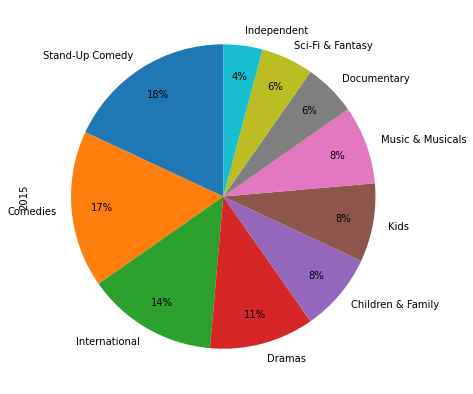

In [193]:
top10_2015.plot(kind='pie', figsize=(7,7), autopct='%1.0f%%', pctdistance=0.8, startangle=90);

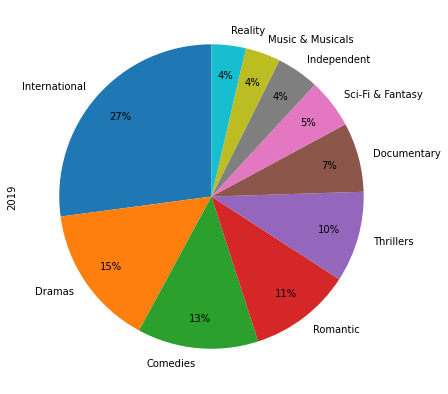

In [194]:
top10_2019.plot(kind='pie', figsize=(7,7), autopct='%1.0f%%', pctdistance=0.8, startangle=90);

## Comments on Top 10
The following statements refer to percentages as a proportion of the top 10 categories for the respective year, not percentages of the total offerings for a given year. 

In 2015 the number one category was Stand-Up Comedy, no longer holds true for 2019. Moving from an initial value of 18%, the share of new content occupied by Stand-Up Comedy fell to less than 4% in 2019, and landed it out of the top ten most popular genres. 

The second most popular genre of 2015 was Comedies, at 17%. In 2019, Comedies has dropped to 3rd place at 13%, being overtaken by Dramas, which boasts a move from 11% and 4th place in 2015, all the way up to 15% in 2019.

International, ranked 3rd by relative frequency in 2015 at 14%, had increased by a huge amount up to 27% in 2019, making it the number on ranked category in 2019.

The 4th position in 2015 was occupied by Drama titles at 11%, by 2019 the Dramas genre had moved up into 2nd place with a share of 15%. In 2019, the Romantic genre had increased from less than 4% in 2015 up to 11%, making it the fourth ranked genre of offering. 

Children & Family, Kids, and Music & Musicals occupied the 5th, 6th, and 7th positions in the rankings in 2015, with each category representing 8% of the top 10. Looking at 2019, only Music & Musicals remains listed in the top 10 genres, falling to the 9th position, and only making up 4% of the top 10 offerings. The 5th, 6th, and 7th posiitons were occupied by Thrillers, Documentary, and Sci-Fi & Fantasy, each at 10%, 7% and 5% respectively.

Overall, there are clearly some title genres that are more resilient than others, with International, Dramas, and Comedies each taking up a massive collective share of 42% of the top 10 in 2015, and an even greater 55% in 2019. 
It appears that these three categories are strongest, having retained high ranking positions throughout the years observed (see *Number of titles added by category by year* cluster chart)

## Visualising the distribution of frequencies
Looking at a histogram of category additions can help to show whether there is a large amount of 'dead weight' in the additions being added. For if there is a high number of unpopular categories, perhaps the resources devoted to these additions should be redirected toward the addition of known favourites.

Text(0, 0.5, 'Frequency')

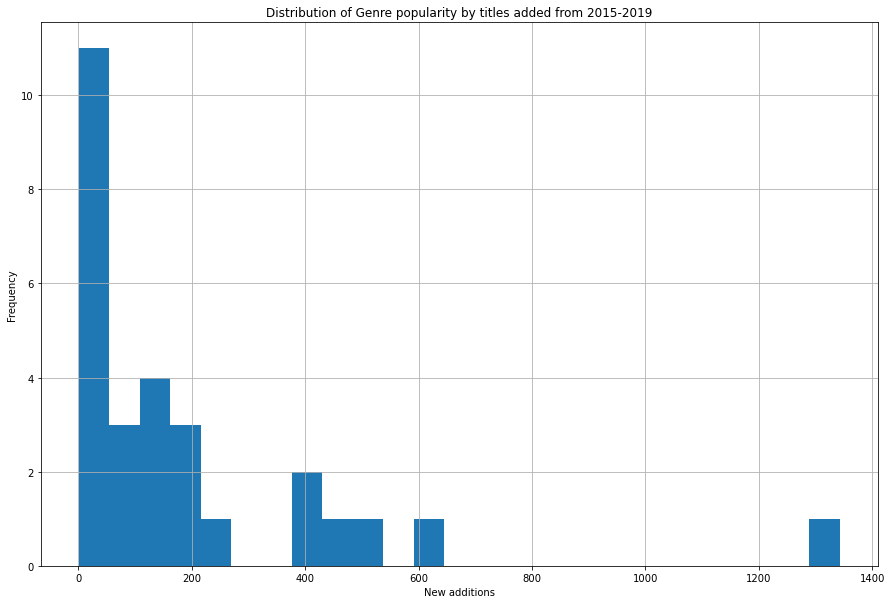

In [206]:
x2['Total']= x.iloc[:, -5:-1].sum(axis=1)
ax = x2['Total'].hist(bins=25, figsize=(15, 10))
ax.set_title('Distribution of Genre popularity by titles added from 2015-2019')
ax.set_xlabel('New additions')
ax.set_ylabel('Frequency')

Indeed, there are many genres that experienced around only 20 additions. The high degree of right skewness of the data indicates that there is extreme variabliity between the popularity of different genres offered, with a large degree of new content being made up by only a few titles, which can be considered outliers. Here we see that while there are many categories offered, most of them do not have a large impact due to their small size. This data fits the narrative of the pareto principal, which states that most of efforts expended are inconsequential to the end outcome, in this case, most categories do not show enough growth in comparison to the few which dominate the titles list

# Research Question 3: What are the differences in trends in overall growth between domestic and non domestic offerings, measured by number of titles added?
To answer this, the total new offerings by country for the sample will be examined, as well as category trends by country.

In [224]:
#Total titles per country
countries = []

def testfunc(countrylist): 
    if isinstance(countrylist, str):
        items = countrylist.split(',')
        for country in items: 
            country = country.strip()
            countries.append(country)

df['country'].apply(testfunc)

countries = pd.Series(countries)
countries.value_counts()

United States     2610
India              838
United Kingdom     602
Canada             318
France             271
                  ... 
Slovakia             1
Somalia              1
Azerbaijan           1
Kuwait               1
Sri Lanka            1
Length: 111, dtype: int64

In [250]:
import pycountry 

countriesdf = pd.DataFrame(countries.value_counts()).reset_index()
countriesdf.columns = ['Country', 'Count']
#Some country names will give problems below
countriesdf.loc[countriesdf['Country'] == 'South Korea', 'Country'] = 'Korea'
countriesdf.loc[countriesdf['Country'] == 'West Germany', 'Country' ] = 'Germany'
countriesdf.loc[countriesdf['Country'] == 'East Germany', 'Country' ] = 'Germany'
countriesdf.loc[countriesdf['Country'] == 'Soviet Union', 'Country' ] = 'Russia'



countriesdf['Code'] = countriesdf['Country'].apply(lambda x: pycountry.countries.search_fuzzy(x)[0].alpha_3)
countriesdf.head()

,Country,Count,Code
0,United States,2610,USA
1,India,838,IND
2,United Kingdom,602,GBR
3,Canada,318,CAN
4,France,271,FRA


In [331]:
print('Total titles added: ', countriesdf['Count'].sum())

Total titles added:  7182


In [220]:
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

In [289]:
mapdata = dict(type='choropleth', 
           locations = countriesdf['Code'], 
           z=countriesdf['Count'], 
           colorbar={'title':'Titles added'}, 
           colorscale='viridis',
               marker_line_color='white')

layout = dict(title = 'Netflix titles added 2008 - 2020', 
             geo = dict(
             showframe = False, 
             projection = {'type':'natural earth'}))

fig = go.Figure(data=[mapdata], layout=layout)
fig.update_geos(showland=True, landcolor='rgb(240,240,240)', showcoastlines=False)

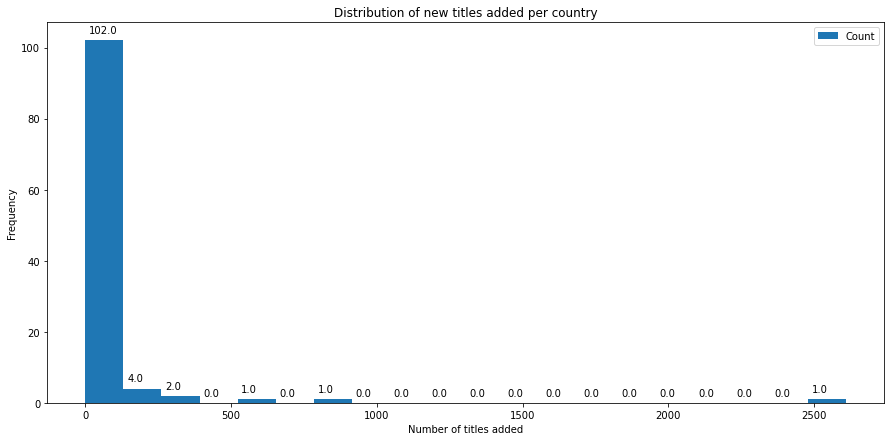

In [318]:
ax = countriesdf.plot(kind='hist', bins=20, figsize=(15, 7 ))
ax.set_xlabel('Number of titles added')
ax.set_title('Distribution of new titles added per country')
#add height label to bins
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + (p.get_width()/10), p.get_height() + 2))

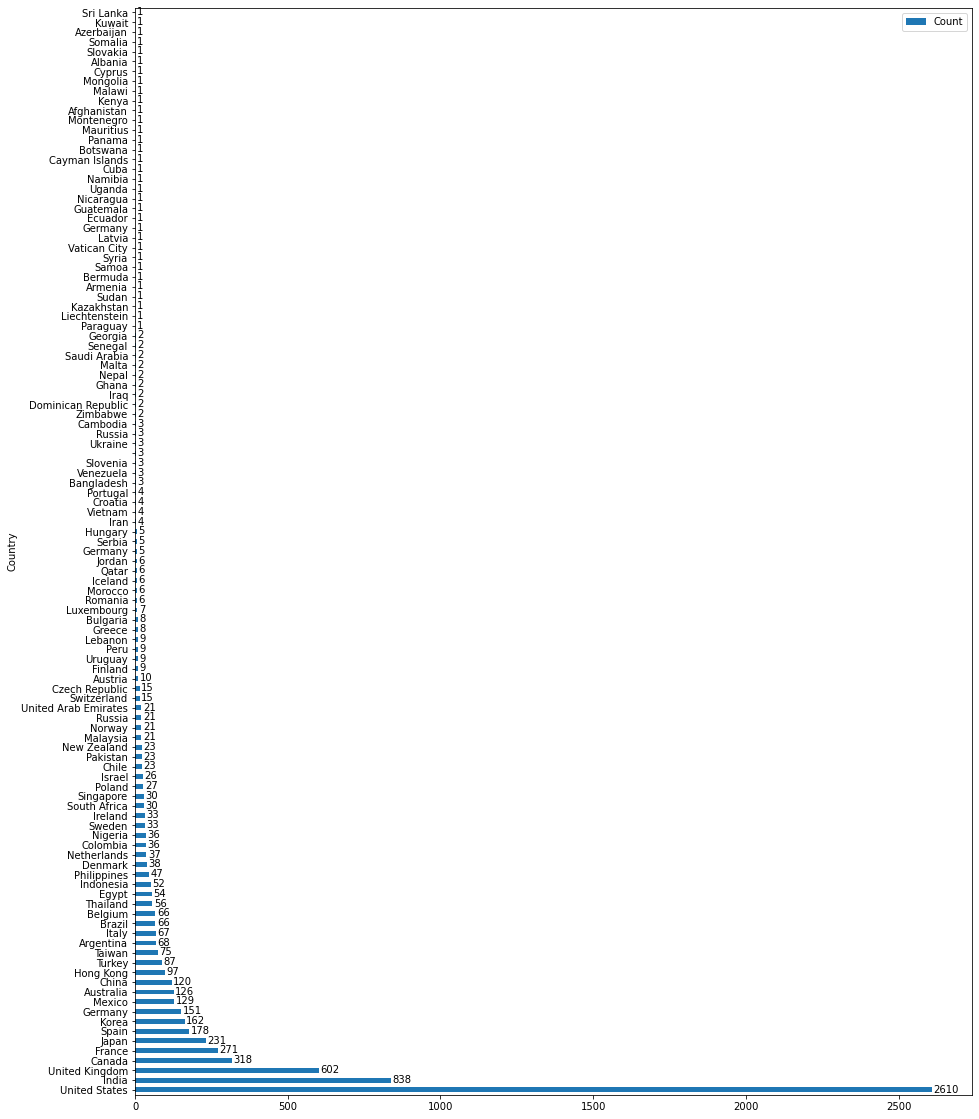

In [326]:
ax = countriesdf.plot(kind='barh', figsize=(15, 20), x='Country')
for p in ax.patches: 
    ax.annotate(str(p.get_width()), (p.get_width() + 5, p.get_y()))

## Observations based on charts
The figures above clearly show that again, most of the audiences served are receiving far less content than the top Country, the USA. 

Looking at the histogram, it shows that the majority of countries, 108 of them or 97%, received less than 500 titles each, and that there was only one instance of a country receiving over 1,000 titles. The single instance of a country with more than 1,000 titles added was the USA at 2,610. This is another example of an extraploation of the Pareto principle, showing that only 3% of total countries is responsible for over 36% of offerings growth. 

Further still, now moving on to the bar chart - Of the 7,182 observations, 2,610 of those went to the USA. That's over 3 times the second most served market of India with only 838 titles. Clearly the USA is the favoured market, and receives a disproportionate share of the title additions in comparison with other countries. 

The top five markets - representing only 0.45% of the available countries, USA, India, United Kingdom, Canada, and France account for 4,638 titles, which represents over 60% of the total number of titles added. 

In [344]:
df.head()

,show_id,type,country,date_added,duration,listed_in
0,81145628,Movie,"United States, India, South Korea, China",2019-09-09,90 min,"Children & Family Movies, Comedies"
1,80117401,Movie,United Kingdom,2016-09-09,94 min,Stand-Up Comedy
2,70234439,TV Show,United States,2018-09-08,1 Season,Kids' TV
3,80058654,TV Show,United States,2018-09-08,1 Season,Kids' TV
4,80125979,Movie,United States,2017-09-08,99 min,Comedies


In [362]:
import numpy as np

In [446]:
# row = countries
# columns = genre
heatmap = pd.DataFrame({'Country': []})

In [447]:
#not working - maybe change the country col to an index?

for index, row in df[['country', 'listed_in']].iterrows(): 
    if isinstance(row['country'], str) and isinstance(row['listed_in'], str):
        countriess = row['country'].split(',')
        genres = row['listed_in'].split(',')
        for c in countriess: 
            c = c.strip()
            for g in genres:
                g = g.strip()
                #if a column exists for this genre
                if g in heatmap.columns: 
                    #if a row exists for this country
                    if (heatmap['Country'] == c).any(): 
                        #increment the cell at [country, genre]
                        heatmap.loc[heatmap['Country'] == c, g] = heatmap.loc[heatmap['Country'] == c, g] + 1
                    #if row doesn't exist
                    else:
                        #add a new row. Create a df with the columns of the current df,
                        #add a country name, and a genre count, then append to heatmap. 
                        newrow = {}
                        for col in heatmap.columns: 
                            newrow[col] = [0]
                            
                        newrow = pd.DataFrame(newrow) 
                        newrow['Country'] = c
                        newrow[g] = 1
                        heatmap = heatmap.append(newrow)
                #if the column does not exist
                else:
                    #create the column
                    heatmap[g] = 0
                    #if a row for this country exists
                    if (heatmap['Country'] == c).any(): 
                        #increment the cell at [country, genre]
                        heatmap.loc[heatmap['Country'] == c, g] = 1
                    #if a row for this country does not exist
                    else: 
                        #add a new row. Create a df with the columns of the current df,
                        #add a country name, and a genre count, then append to heatmap. 
                        newrow = {}
                        for col in heatmap.columns: 
                            newrow[col] = [0]
                            
                        newrow = pd.DataFrame(newrow)
                        newrow['Country'] = c
                        newrow[g] = 1
                        heatmap = heatmap.append(newrow)
                
                
heatmap

,Country,Children & Family Movies,Comedies,Stand-Up Comedy,Kids' TV,Crime TV Shows,International TV Shows,Spanish-Language TV Shows,International Movies,Sci-Fi & Fantasy,...,Anime Series,LGBTQ Movies,TV Horror,Movies,Stand-Up Comedy & Talk Shows,TV Sci-Fi & Fantasy,Classic Movies,Sports Movies,TV Shows,Classic & Cult TV
0,United States,258,447,186,157,115,56,25,116,134,...,9,39,30,23,27,50,61,84,3,16
0,India,15,246,1,5,7,48,0,719,11,...,0,2,6,0,1,3,12,14,2,0
0,South Korea,5,10,2,16,16,97,1,34,4,...,1,0,0,1,4,0,0,0,0,0
0,China,9,23,0,4,4,31,0,59,11,...,0,0,0,0,0,3,0,0,0,0
0,United Kingdom,24,67,17,21,43,106,1,126,28,...,0,4,4,3,1,3,11,18,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Bermuda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ecuador,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Syria,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Kuwait,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Country'>

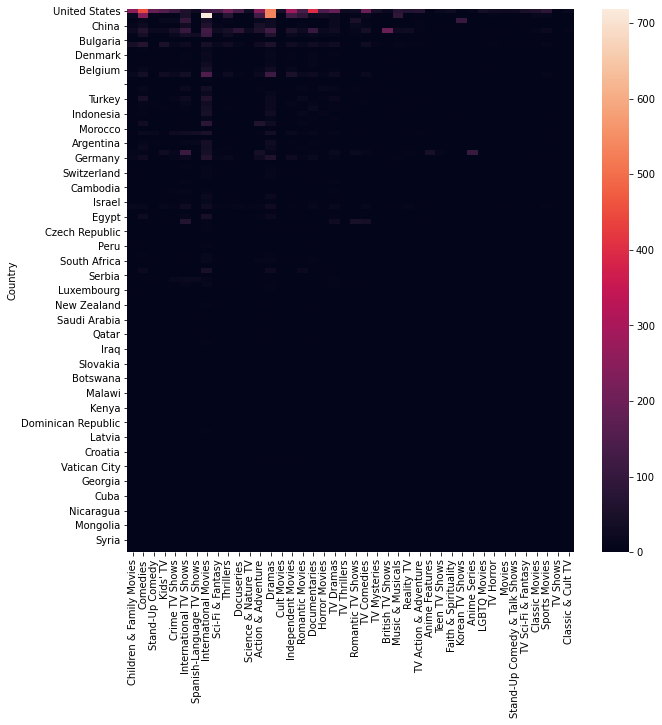

In [450]:
import seaborn as sns 
import matplotlib.pyplot as plt

heatmap = heatmap.set_index('Country')
plt.subplots(figsize=(10,10))
sns.heatmap(heatmap)

In [494]:
#The above chart is useless. All figures dwarfed in comparison to the numbers of the USA, 
#so even if a genre is popular within the context of a country's population, it is difficult to see. 
#There are also too many genres listed, so some of the genres will be grouped.
family = ['Children & Family Movies']
kids = ["Kids' TV", ]
comedy = ['Comedies', 'Stand-Up Comedy', 'TV Comedies', 'Stand-Up Comedy & Talk Shows']
international = ['International TV Shows', 'International Movies']
drama = ['Dramas', 'TV Dramas']
documentaries = ['Documentaries', 'Docuseries', ]
horror = ['TV Horror', 'Horror Movies']
thriller = ['TV Thrillers', 'Thrillers']
romantic = ['Romantic Movies', 'Romantic TV Shows']
actionadventure = ['Action & Adventure', 'TV Action & Adventure']
scifi = ['TV Sci-Fi & Fantasy', 'Sci-Fi & Fantasy']
anime = ['Anime Features', 'Anime Series']

def columnsum(colslist, df, newcolname): 
    df[newcolname] = 0
    for c in colslist: 
        df[newcolname] = df[newcolname] + df[c]
    
    return df.drop(columns=colslist)
    
heatmap2 = heatmap 
heatmap2 = columnsum(family, heatmap2, 'family')
heatmap2 = columnsum(kids, heatmap2, 'kids')
heatmap2 = columnsum(comedy, heatmap2, 'comedy')
heatmap2 = columnsum(international, heatmap2, 'international')
heatmap2 = columnsum(drama, heatmap2, 'drama')
heatmap2 = columnsum(documentaries, heatmap2, 'documentary')
heatmap2 = columnsum(horror, heatmap2, 'horror')
heatmap2 = columnsum(thriller, heatmap2, 'thriller')
heatmap2 = columnsum(romantic, heatmap2, 'romantic')
heatmap2 = columnsum(actionadventure, heatmap2, 'action and adventure')
heatmap2 = columnsum(scifi, heatmap2, 'scifi')
heatmap2 = columnsum(anime, heatmap2, 'anime')

heatmap2

,Crime TV Shows,Spanish-Language TV Shows,Science & Nature TV,Cult Movies,Independent Movies,TV Mysteries,British TV Shows,Music & Musicals,Reality TV,Teen TV Shows,...,comedy,international,drama,documentary,horror,thriller,romantic,action and adventure,scifi,anime
Country,,,,,,,,,,,,,,,,,,,,,
United States,115,25,31,37,287,44,22,77,67,20,...,855,172,722,535,175,225,160,320,184,12
India,7,0,0,4,128,3,0,92,2,1,...,263,767,560,30,37,75,97,130,14,0
South Korea,16,1,0,1,2,0,0,1,4,0,...,23,131,41,2,3,12,50,22,4,1
China,4,0,0,1,1,1,1,1,0,3,...,32,90,44,6,1,4,27,53,14,1
United Kingdom,43,1,25,5,52,3,192,23,27,0,...,123,232,149,188,26,46,32,65,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bermuda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Ecuador,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Syria,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


<AxesSubplot:ylabel='Country'>

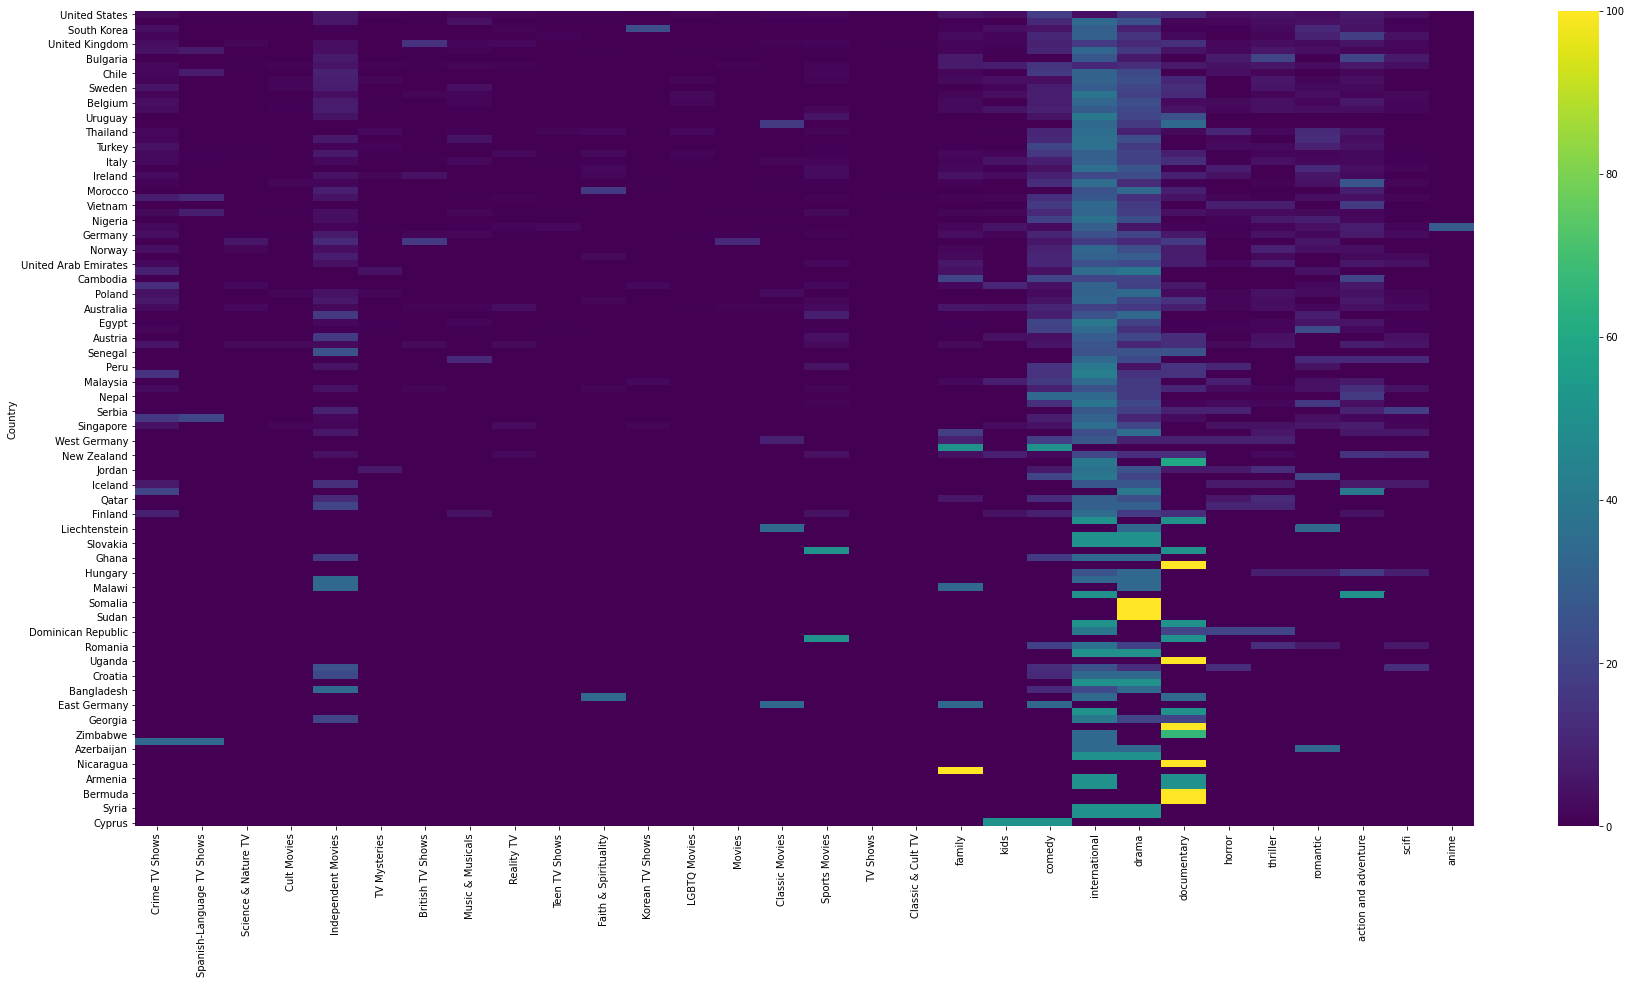

In [495]:
#For a more insightful chart, the cell values from absolute numbers, to % share of total offerings by country instead.
percentheatmap = heatmap2.apply(lambda x: (x*100)/ heatmap2[list(heatmap2.columns)].sum(axis=1))
plt.subplots(figsize=(30,15))
sns.heatmap(percentheatmap, cmap='viridis')

## Observations 
This chart is much clearer than the first one, and it shows some obvious patterns.
Unsurprisingly, the International category is internationally very popular. 
Other categories that are quite popular internationally include: comedy, drama, and documentary.
This is quite interesting, as one does not necessarily expect the popular categories to be popular in all countries, since cultures vary greatly. It might have been more intuitive to assume that some countries were distorting the average, but as the data show this is not the case - instead, popular categories like drama, international, comedy, are popular throughout. This finding is emphasised when observing the clustermap of US data vs Foreign. The most prominent categories stand out in both US and Foreign, indicating that while the above studies show there are certainly less titles going to Foreign audiences, the overall composition of the offerings is largely the same. 
This could mean that there is potential for growth. If the offering of content is reflective of the audience's demand and their preferences, it is reasonable to assume that these foreign markets would also enjoy the titles they are not receiving, and that the number of offerings they receive has room to be increased. 

In [547]:
foreign = heatmap2.loc['India':].sum(axis=0).to_frame().transpose()
foreign.index = ['Foreign']
domestic = heatmap2.loc['United States'].to_frame().transpose()

In [548]:
usvsforeign = domestic.append(foreign)
usvsforeign = usvsforeign.apply(lambda x: (x*100)/ usvsforeign[list(usvsforeign.columns)].sum(axis=1))
usvsforeign

,Crime TV Shows,Spanish-Language TV Shows,Science & Nature TV,Cult Movies,Independent Movies,TV Mysteries,British TV Shows,Music & Musicals,Reality TV,Teen TV Shows,...,comedy,international,drama,documentary,horror,thriller,romantic,action and adventure,scifi,anime
United States,2.417998,0.525652,0.651808,0.777965,6.034483,0.925147,0.462574,1.619008,1.408747,0.420521,...,17.977292,3.616484,15.180824,11.248949,3.679563,4.730866,3.364172,6.728343,3.868797,0.252313
Foreign,2.441671,1.003798,0.397902,0.316513,4.141798,0.298426,1.971423,1.528305,0.660156,0.198951,...,10.372581,28.513294,17.589076,5.127509,1.917164,3.201302,4.621089,5.652017,1.573521,1.392657


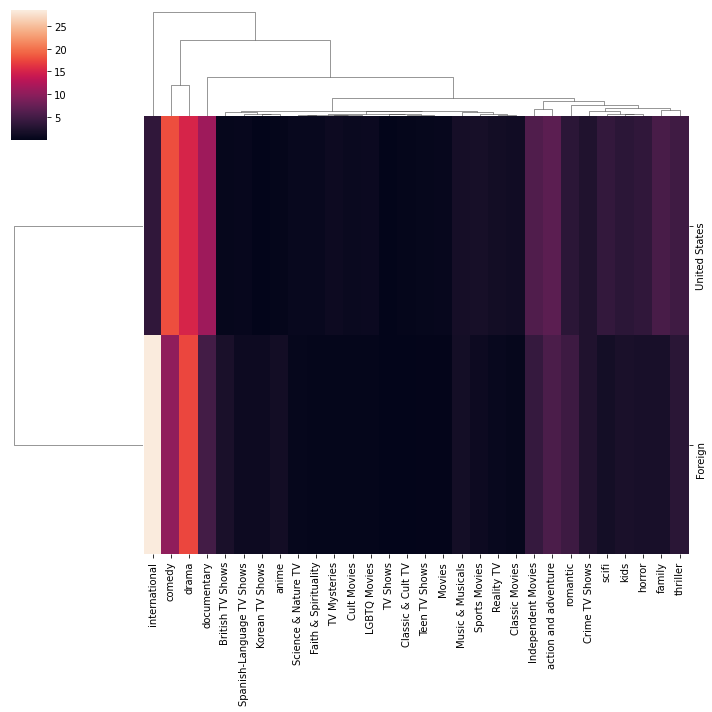

In [551]:
sns.clustermap(usvsforeign)